In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train = pd.DataFrame.from_csv("./train_full.csv",index_col=None)

train[:10]

,Unnamed: 0,cancel_time,dist,driver_found,due,f_class,lat,lon,s_class,t_class,burned,time_of_day,day_of_week,day_abs
0,1519921,-1,3649.475196,True,2014-03-19 02:45:00.000,econom,55.776806,37.639887,NaN,NaN,False,0.114583,3,735311
1,2330264,-1,18706.794099,True,2014-04-26 06:05:00.000,econom,55.728728,37.644657,NaN,NaN,False,0.253472,6,735349
2,2048412,-1,13831.118456,True,2014-04-12 19:15:00.000,econom,55.782818,37.734812,NaN,NaN,False,0.802083,6,735335
3,621339,-1,10048.788267,True,2014-02-03 06:00:00.000,econom,55.904064,37.549417,NaN,NaN,False,0.250000,1,735267
4,2211165,-1,-1.000000,True,2014-04-20 16:25:00.000,econom,55.767820,37.568354,NaN,NaN,False,0.684028,7,735343
5,228457,-1,16818.028015,True,2014-01-15 10:40:00.000,econom,55.639491,37.524963,NaN,NaN,False,0.444444,3,735248
6,2180809,-1,5091.525409,True,2014-04-19 11:30:00.000,econom,55.763356,37.551259,NaN,NaN,False,0.479167,6,735342
7,289025,-1,19951.487846,True,2014-01-18 12:00:00.000,econom,55.880515,37.582861,NaN,NaN,False,0.500000,6,735251
8,1514892,-1,-1.000000,True,2014-03-18 18:00:00.000,econom,55.593779,37.605366,NaN,NaN,False,0.750000,2,735310
9,3114020,-1,20602.942560,True,2014-05-31 23:30:00.000,econom,55.771297,37.490353,NaN,NaN,False,0.979167,6,735384


In [3]:
from sklearn.cross_validation import train_test_split


orders = train[["lon","lat","time_of_day"]].values[:100000]

Xtr, Xval = train_test_split(orders,test_size = 0.5,random_state=32)



# baseline

* просто запоминаем долю людей по квадратам (широта, долгота, время дня)
* смазываем лапласом

In [28]:
grid_range=[
    (29.756550000000001, 55.750618000000003),
    (37.3951476015, 60.165199999999999),
    (0.0, 0.99861111111099998)
]
grid_size = [2500,2500,24]

bin_area = np.prod([
        abs(rg[1]-rg[0])/n_bins
                        for rg,n_bins in zip(grid_range,grid_size)])


counts,_= np.histogramdd(Xtr,bins=grid_size,range=grid_range)

In [53]:


smoothing_numerator = 1e-7
smoothing_denominator =  smoothing_numerator* np.prod(grid_size)



denominator = (float(len(Xtr))+ smoothing_denominator) / grid_area

counts_smooth = (counts+smoothing_numerator)

probas = counts_smooth/denominator

logprobas = np.log(probas)

In [54]:
val_counts,_ = np.histogramdd(Xval,bins=grid_size,range=grid_range)
train_counts,_ = np.histogramdd(Xtr,bins=grid_size,range=grid_range)


print  'llh/s train', np.sum(logprobas*train_counts) / len(Xtr)
print  'llh/s val', np.sum(logprobas*val_counts) / len(Xval)


llh/s train -3.10322213371
llh/s val -6.70182665513


In [44]:
assert np.sum(probas)/grid_area - 1 < 1e-5

# spatial gmm
* train gmm with weights inited with k-means (just works a bit better than training gmm fro ms)


In [58]:
#divide by time range since we predict uniformly in time
spatial_gmm_denominator = Xtr[:,2].max() - Xtr[:,2].min()

In [66]:
from sklearn.mixture import  GMM
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split


kmeans = KMeans(n_clusters=500,n_init=10,n_jobs=-1)

kmeans.fit(Xtr[:,:2])

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=500, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [68]:
gmm = GMM(n_components=500,params='wc',init_params='wc',covariance_type= 'spherical' )
#pseudo-fit

gmm.means_ = kmeans.cluster_centers_

gmm.fit(Xtr[:,:2])
assert np.allclose(kmeans.cluster_centers_ , gmm.means_)

In [71]:
#dare you say i should use sum()? 
train_llh = gmm.score(Xtr[:,:2]).mean() - np.log( spatial_gmm_denominator)
test_llh =  gmm.score(Xval[:,:2]).mean() - np.log( spatial_gmm_denominator )

print train_llh,test_llh

1.84837888073 0.668752675573


<matplotlib.colorbar.Colorbar instance at 0x7f15baf56b00>

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


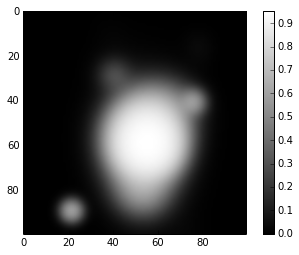

In [72]:
xgrid = np.linspace(37,38,100)
ygrid = np.linspace(55.2,56.2,100)

from itertools import product

grid = product(xgrid,ygrid)
grid = np.array(list(grid))


from scipy.special import expit

pdf = expit( gmm.score(grid))

plt.imshow(pdf.reshape(-1,100),cmap='gray')
plt.colorbar()

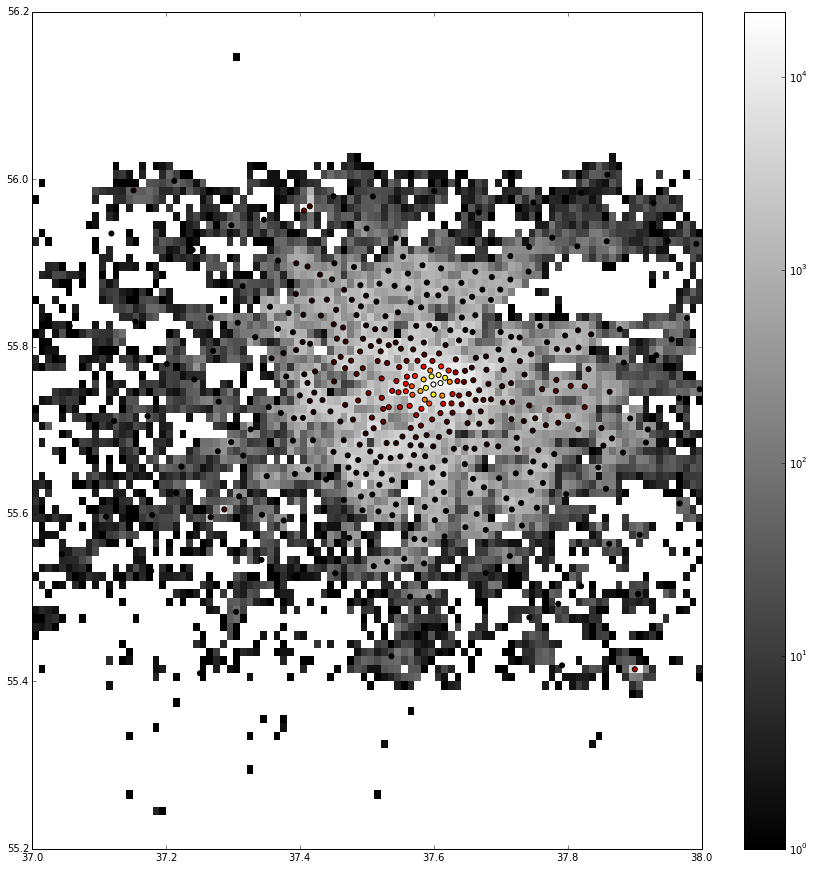

In [88]:
from matplotlib.colors import LogNorm

centers = gmm.means_
weights = gmm.weights_
plt.figure(figsize=[15,15])
_=plt.hist2d(train.lon,train.lat,range=[(37,38),(55.2,56.2)],bins=[100,100],cmap='gray',norm = LogNorm())

plt.colorbar()

plt.scatter(centers[:,0],centers[:,1],marker='.',s=100,cmap='hot',c = weights)





# gmm with time


In [90]:
kmeans = KMeans(n_clusters=2000,n_init=10,n_jobs=-1)

kmeans.fit(Xtr)


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2000,
    n_init=10, n_jobs=-1, precompute_distances='auto', random_state=None,
    tol=0.0001, verbose=0)

In [102]:
gmm = GMM(n_components=2000,params='wc',init_params='wc',covariance_type= 'spherical' ,min_covar=0.01)
#pseudo-fit

gmm.means_ = kmeans.cluster_centers_

gmm.fit(Xtr)
assert np.allclose(kmeans.cluster_centers_ , gmm.means_)

In [103]:
#dare you say i should use sum()? 
train_llh = gmm.score(Xtr).mean()
test_llh =  gmm.score(Xval).mean()

print "llh on train:",train_llh
print "llh on test:",test_llh

llh on train: 1.33090108814
llh on test: 1.32519343345
